# 📺 View channels

In [ ]:
#| default_exp repr_chans

In [ ]:
# |hide
from fastcore.test import test_eq
from nbdev.showdoc import *
from lovely_tensors import monkey_patch

In [ ]:
# |hide
monkey_patch()

In [ ]:
# |hide
# |export
from typing import Any, Optional as O
from functools import cached_property

import torch
from matplotlib import pyplot as plt, axes, figure
from IPython.core.pylabtools import print_figure

from lovely_numpy.repr_chans import fig_chans
from lovely_tensors.utils.misc import to_numpy

In [ ]:
# |exporti
class ChanProxy():   
    def __init__(self, t: torch.Tensor):
        self.t = t
        self.params = dict(cmap = "twilight", 
                    cm_below="blue",
                    cm_above="red",
                    cm_ninf="cyan",
                    cm_pinf="fuchsia",
                    cm_nan="yellow",
                    view_width=966,
                    gutter_px=3,
                    frame_px=1,
                    scale=1,
                    cl=False,
                    ax=None)

    def __call__(self,
                 cmap       :O[str]=None, 
                 cm_below   :O[str]=None,
                 cm_above   :O[str]=None,
                 cm_ninf    :O[str]=None,
                 cm_pinf    :O[str]=None,
                 cm_nan     :O[str]=None,
                 view_width :O[int]=None,
                 gutter_px  :O[int]=None,
                 frame_px   :O[int]=None,
                 scale      :O[int]=None,
                 cl         :Any=None,
                 ax         :O[axes.Axes]=None):
        
        self.params.update( {   k:v for
                                k,v in locals().items()
                                if k != "self" and v is not None } )
        _ = self.fig # Trigger figure generation
        return self

    @cached_property
    def fig(self) -> figure.Figure:
        return fig_chans(to_numpy(self.t), **self.params, )

    def _repr_png_(self):
        return print_figure(self.fig, fmt="png", pad_inches=0,
            metadata={"Software": "Matplotlib, https://matplotlib.org/"})

In [ ]:
# |export
def chans(  x: torch.Tensor,                # Input, shape=([...], H, W)
            cmap        :str    ="twilight",# Use matplotlib colormap by this name
            cm_below    :str    ="blue",    # Color for values below -1
            cm_above    :str    ="red",     # Color for values above 1
            cm_ninf     :str    ="cyan",    # Color for -inf values
            cm_pinf     :str    ="fuchsia", # Color for +inf values
            cm_nan      :str    ="yellow",  # Color for NaN values
            view_width  :int    =966,       # Try to produce an image at most this wide
            gutter_px   :int    =3,         # Draw write gutters when tiling the images
            frame_px    :int    =1,         # Draw black frame around each image
            scale       :int    =1,
            cl          :Any    =False,
            ax          :O[axes.Axes]=None
        ) -> ChanProxy:

    "Map tensor values to colors. RGB[A] color is added as channel-last"
    args = locals()
    del args["x"]

    return ChanProxy(x)(**args)

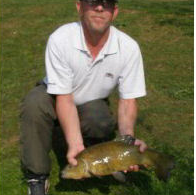

In [ ]:
in_stats = ( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) )

image = torch.load("mysteryman.pt")
image = (image * torch.tensor(in_stats[1])[:,None,None])
image += torch.tensor(in_stats[0])[:,None,None]

image.rgb

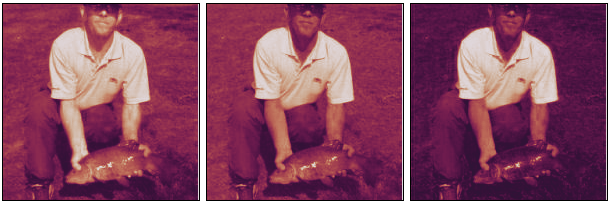

In [ ]:
chans(image)

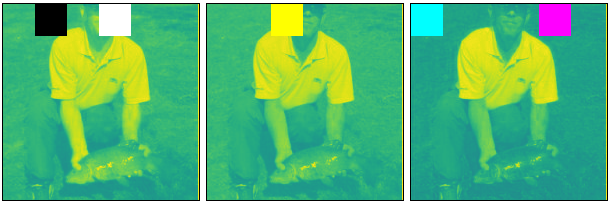

In [ ]:
# In R
image[0,0:32,32:64] = -1.1 # Below min
image[0,0:32,96:128] = 1.1 # Above max
# In G
image[1,0:32,64:96] = float("nan")
# In B
image[2,0:32,0:32] = float("-inf")
image[2,0:32,128:128+32] = float("+inf")

chans(image, cmap="viridis", cm_below="black", cm_above="white")

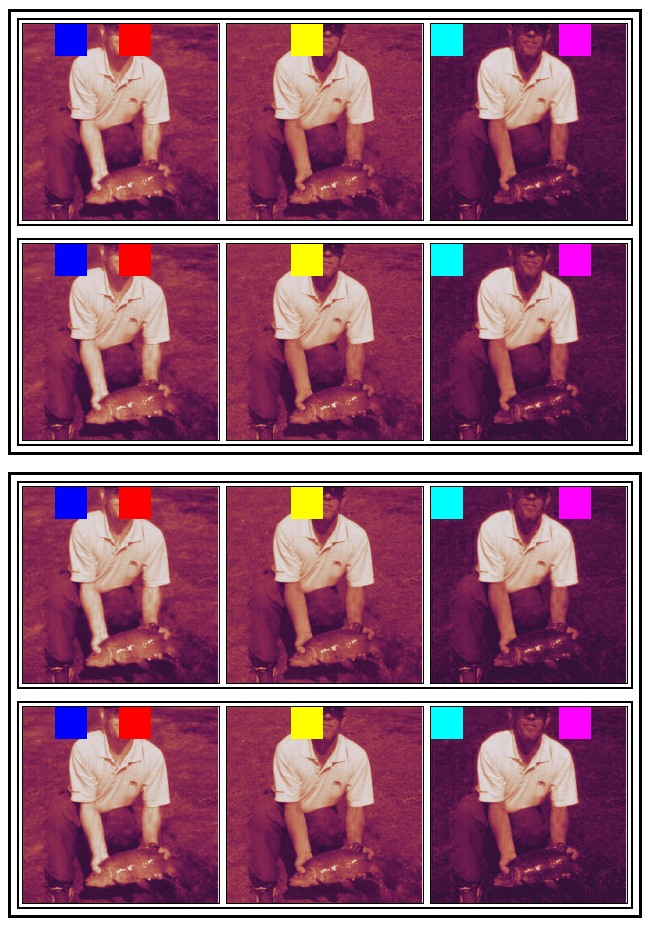

In [ ]:
# 4 images, stacked 2x2
chans(torch.stack([image]*4).view(2,2,3,196,196))

In [ ]:
# |hide

try:
    chans(torch.tensor([]).view((0,0,0))).fig
except AssertionError as e:
    test_eq(e.args[0], "Expecting non-empty input, got shape=((0, 0, 0, 3))")
else:
    raise AssertionError("Expected AssertionError, but got nothing")    


In [ ]:
# |hide
import gc

before allocation: torch.cuda.memory_allocated()=0
after allocation: torch.cuda.memory_allocated()=262144


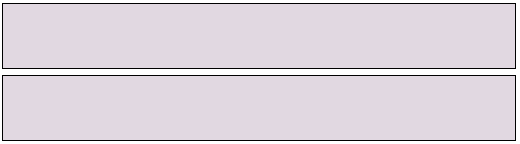

after rgb: torch.cuda.memory_allocated()=262144
after cleanup: torch.cuda.memory_allocated()=0


In [ ]:
# |hide
if torch.cuda.is_available():
    cudamem = torch.cuda.memory_allocated()
    print(f"before allocation: {torch.cuda.memory_allocated()=}")
    numbers = torch.ones((2,64, 512), device="cuda")
    torch.cuda.synchronize()
    print(f"after allocation: {torch.cuda.memory_allocated()=}")
    display(chans(numbers))
    print(f"after rgb: {torch.cuda.memory_allocated()=}")
   
    del numbers
    gc.collect()
    # torch.cuda.memory.empty_cache()
    # torch.cuda.synchronize()

    print(f"after cleanup: {torch.cuda.memory_allocated()=}")
    test_eq(cudamem >= torch.cuda.memory_allocated(), True)

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()